2022-07-25 20:00:27.182896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-25 20:00:27.182913: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-25 20:00:28.603868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-25 20:00:28.603886: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-25 20:00:28.603895: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (imasonliu-LC11): /proc/driver/nvidia/version does not exist
2022-07-25 20:00:28.604082: I tensorflow/core/platform/cpu_fea

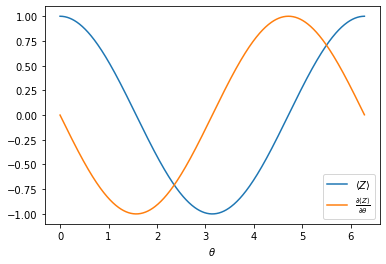

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorcircuit as tc

K = tc.set_backend("tensorflow")


@K.jit
def exp_z(param):
    c = tc.Circuit(1)
    c.rx(0, theta=param)
    return K.real(c.expectation_ps(z=[0]))


grad_z = K.grad(exp_z)

params = K.convert_to_tensor(np.arange(0, 2 * np.pi, 0.01))

plt.plot(params, [exp_z(param) for param in params], label=r"$\langle Z\rangle$")
plt.plot(
    params,
    [grad_z(param) for param in params],
    label=r"$\frac{\partial \langle Z\rangle}{\partial \theta}$",
)
plt.legend()
plt.xlabel(r"$\theta$")
plt.show()


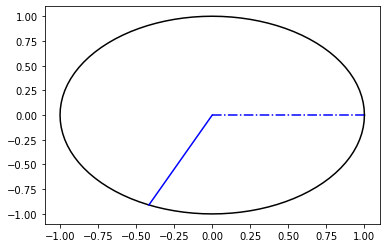

In [2]:
def R(t):
    return np.array([[np.cos(t),np.sin(t)],[-np.sin(t),np.cos(t)]])
def draw_circle(ox,oy,r,point_num,avg=""):
    x_arr,y_arr=[],[]
    for i in range(point_num+1):
        t=np.pi*2/point_num*i;
        x_arr.append(ox+r*np.cos(t))
        y_arr.append(oy+r*np.sin(t))
    plt.plot(x_arr,y_arr,avg)
def draw_line(ax,ay,bx,by,avg=""):
    x_arr,y_arr=[ax,bx],[ay,by]
    plt.plot(x_arr,y_arr,avg)

v0=np.array([[1],[0]])
v0_=np.matmul(R(2),v0)

plt.clf()
draw_circle(0,0,1,100,'k-')
draw_line(0,0,1,0,'b-.')
draw_line(0,0,v0_[0][0],v0_[1][0],'b')
plt.show()

In [3]:
from scipy import linalg

def I(n):
    return np.array([1 if i%(n+1)==0 else 0 for i in range(n*n)]).reshape(n,n)
def ZERO(n):
    return np.array([0 for i in range(n*n)]).reshape(n,n)
def _exp(mat,t):
    return np.cos(t)*I(mat.shape[0])+1j*np.sin(t)*mat;

print(I(3))
print(_exp(I(3),1))
print(linalg.expm(I(3)*1j))

[[1 0 0]
 [0 1 0]
 [0 0 1]]
[[0.54030231+0.84147098j 0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.54030231+0.84147098j 0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.54030231+0.84147098j]]
[[0.54030231+0.84147098j 0.        +0.j         0.        +0.j        ]
 [0.        +0.j         0.54030231+0.84147098j 0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.54030231+0.84147098j]]


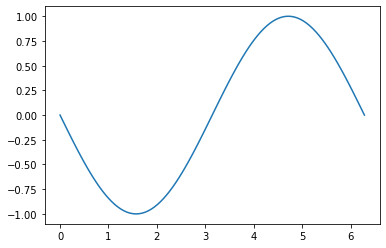

In [4]:
def conj_tr(v):
    return np.conj(v.transpose())
def expect(mat,v):
    return np.matmul(np.matmul(conj_tr(v),mat),v)[0][0]

tx=np.array([[0,1],[1,0]])
ty=np.array([[0,-1j],[1j,0]])
tz=np.array([[1,0],[0,-1]])

def test_1(id1,id2):
    Mat=[I(2),tx,ty,tz]
    class test_1_helper:
        def __init__(self,p,q):
            self.P=p
            self.Q=q
        def __call__(self,t):
            vt=np.matmul(_exp(self.P,t/2),v0)
            return expect(self.Q,vt).real
    return test_1_helper(Mat[id1],Mat[id2])

def draw_function(f,s,t,point_num,avg=""):
    x_arr,y_arr=[],[]
    for i in range(point_num+1):
        v=s+(t-s)*1./point_num*i;
        x_arr.append(v)
        y_arr.append(f(v))
    plt.clf()
    plt.plot(x_arr,y_arr)
    plt.show()
    
draw_function(test_1(2,1),0,np.pi*2,100)

In [5]:
def multi_kron(arr):
    ans=I(1)
    for i in arr:
        ans=np.kron(ans,i)
    return ans

def test_2(n):
    ans=ZERO(2**n)
    for i in range(n):
        ans+=multi_kron([I(2) if i!=j else tz for j in range(n)])
    for i in range(n-1):
        ans+=multi_kron([I(2) if i!=j and i+1!=j else tx for j in range(n)])
    return (ans,expect(ans,np.array([1 if i==0 else 0 for i in range(2**n)]).reshape(2**n,1)))

print(test_2(3))

(array([[ 3,  0,  0,  1,  0,  0,  1,  0],
       [ 0,  1,  1,  0,  0,  0,  0,  1],
       [ 0,  1,  1,  0,  1,  0,  0,  0],
       [ 1,  0,  0, -1,  0,  1,  0,  0],
       [ 0,  0,  1,  0,  1,  0,  0,  1],
       [ 0,  0,  0,  1,  0, -1,  1,  0],
       [ 1,  0,  0,  0,  0,  1, -1,  0],
       [ 0,  1,  0,  0,  1,  0,  0, -3]]), 3)


In [6]:
v1=np.array([[0],[1]])
print(1/np.sqrt(2)*(multi_kron([v0,v1,v0])-multi_kron([v1,v0,v1])))

[[ 0.        ]
 [ 0.        ]
 [ 0.70710678]
 [ 0.        ]
 [ 0.        ]
 [-0.70710678]
 [ 0.        ]
 [ 0.        ]]


In [7]:
def number_differential(f,x,delta):
    return (f(x+delta)-f(x))/delta
def sin_number_differential(x,delta=1):
    t=np.sin(delta)*2
    return (np.sin(x+delta)-np.sin(x-delta))/t

print(np.cos(1),sin_number_differential(1))

0.5403023058681398 0.5403023058681398


In [8]:
def test_1_differential(v1,v2,x):
    return (test_1(v1,v2)(x+1)-test_1(v1,v2)(x-1))/(np.sin(1)*2)
def test_1_number_differential(v1,v2,x,delta):
    return number_differential(test_1(v1,v2),x,delta)

print(test_1_differential(2,1,1))
print(test_1_number_differential(2,1,1,0.0000001))

-0.5403023058681398
-0.5403022640404487


In [9]:
def test_3(n):
    c=tc.Circuit(n)
    c.H(0)
    for i in range(1,n):
        c.CNOT(0,i)
    print(c.draw())
    print(c.state())

    c=tc.Circuit(n)
    for i in range(n):
        c.H(i)
    print(c.draw())
    print(c.state())

def test_4():
    c=tc.Circuit(3)
    c.ANY(0,unitary=tc.array_to_tensor([[1,0],[0,1]]),name="U1")
    c.ANY(1,unitary=tc.array_to_tensor([[0,1],[1,0]]),name="U2")
    c.H(2)
    c.cswap(2,0,1)
    print(c.draw())
    print(c.state())

test_3(4)
test_4()

     ┌───┐               
q_0: ┤ H ├──■────■────■──
     └───┘┌─┴─┐  │    │  
q_1: ─────┤ X ├──┼────┼──
          └───┘┌─┴─┐  │  
q_2: ──────────┤ X ├──┼──
               └───┘┌─┴─┐
q_3: ───────────────┤ X ├
                    └───┘
tf.Tensor(
[0.70710677+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710677+0.j], shape=(16,), dtype=complex64)
     ┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     └───┘
tf.Tensor(
[0.24999997+0.j 0.24999997+0.j 0.24999997+0.j 0.24999997+0.j
 0.24999997+0.j 0.24999997+0.j 0.24999997+0.j 0.24999997+0.j
 0.24999997+0.j 0.24999997+0.j 0.24999997+0.j 0.24999997+0.j
 0.24999997+0.j 0.24999997+0.j 0.24999997+0.j 0.24999997+0.j], shape=(16,), dtype=complex64)
     ┌────┐   
q_0: ┤ U1 ├─X─
     ├────┤ │ 
q_1: ┤ U2 ├─X─
     ├───┬┘ │ 
q_2: ┤ H ├──■─
   

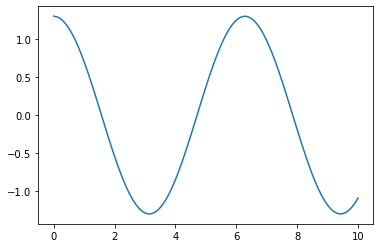

In [10]:
def exp_sumz(n, nlayers, param):
    c = tc.Circuit(n)
    for j in range(nlayers):
        for i in range(n):
            c.rx(i, theta=param[i][j])
        for i in range(n - 1):
            c.cnot(i, i + 1)
#    print(c.draw())
    return K.real(K.sum([c.expectation_ps(z=[i]) for i in range(n)]))

def test_5(t):
    param = [
        [1, t],
        [3, 4]
    ]
    return exp_sumz(2, 2, param)

draw_function(test_5,0,10,100)

In [11]:
def test_6():
    c=tc.Circuit(2)
    c.cnot(0,1)
    c.cnot(1,0)
    c.cnot(0,1)
    print(c.draw())
    print(c.matrix())
test_6()

          ┌───┐     
q_0: ──■──┤ X ├──■──
     ┌─┴─┐└─┬─┘┌─┴─┐
q_1: ┤ X ├──■──┤ X ├
     └───┘     └───┘
tf.Tensor(
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]], shape=(4, 4), dtype=complex64)


In [12]:
def test_7(t):
    c=tc.Circuit(2)
#     c.rz(0,theta=t)
    c.cnot(0,1)
    c.rz(1,theta=t)
    c.cnot(0,1)
    c.cnot(1,0)
    c.rz(0,theta=t)
    c.cnot(1,0)
    print(c.draw())
    print(c.matrix())
    
    c=tc.Circuit(2)
    c.rzz(0,1,theta=t)
    print(c.draw())
    print(c.matrix())
test_7(0.5)

# Too difficult!

                          ┌───┐┌─────────┐┌───┐
q_0: ──■───────────────■──┤ X ├┤ Rz(0.5) ├┤ X ├
     ┌─┴─┐┌─────────┐┌─┴─┐└─┬─┘└─────────┘└─┬─┘
q_1: ┤ X ├┤ Rz(0.5) ├┤ X ├──■───────────────■──
     └───┘└─────────┘└───┘                     
tf.Tensor(
[[0.87758255-0.47942555j 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.87758255+0.47942555j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.87758255+0.47942555j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.        +0.j
  0.87758255-0.47942555j]], shape=(4, 4), dtype=complex64)
     ┌──────┐
q_0: ┤1     ├
     │  rzz │
q_1: ┤0     ├
     └──────┘
tf.Tensor(
[[0.87758255-0.47942555j 0.        +0.j         0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.87758255+0.47942555j 0.        +0.j
  0.        +0.j        ]
 [0.        +0.j         0.        +0.j         0.87758255+0.47942555j
  0.        +0.j      

In [13]:
def hmtest(s, u):
    np.testing.assert_allclose(
        np.conj(u) @ np.transpose(u), np.eye(u.shape[-1]), atol=1e-6
    )
    input_state = np.kron(np.array([1, 0]), s)
    n = int(np.log(s.shape[-1]) / np.log(2))
    print(n)
    c = tc.Circuit(n + 1, inputs=input_state)
    c.H(0)
    c.multicontrol(*range(n + 1), ctrl=[1], unitary=u)
    c.H(0)
    print(c.draw())
    print(c.state())
    return c.expectation_ps(z=[0])


hmtest(
    np.array([1, 0, 0, 0]),
    np.kron(np.array([[1.0, 1], [1, -1]])/np.sqrt(2), np.array([[1.0, 1], [1, -1]])/np.sqrt(2)),
)

2
     ┌───┐┌───────────────┐┌───┐
q_0: ┤ H ├┤2              ├┤ H ├
     └───┘│               │└───┘
q_1: ─────┤1 multicontrol ├─────
          │               │     
q_2: ─────┤0              ├─────
          └───────────────┘     
tf.Tensor(
[ 0.74999994+0.j  0.24999999+0.j  0.24999999+0.j  0.24999999+0.j
  0.24999999+0.j -0.24999999+0.j -0.24999999+0.j -0.24999999+0.j], shape=(8,), dtype=complex64)


<tf.Tensor: shape=(), dtype=complex64, numpy=(0.49999997+0j)>